# 0. Import necessary Libraries

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from shapely.geometry import Point
from geopy.distance import geodesic
import networkx as nx
from sklearn.metrics.pairwise import haversine_distances

# 1. Load the data

In [3]:
shapefile_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\Data\taxi_zones\taxi_zones\taxi_zones.shp"
zone_info_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\Data\taxi_zone_lookup.csv"
demand_data_path = r"C:\Users\Paula\OneDrive\Matematicas y estadistia-UCM\Matematicas y estadistica\TFG\Base de datos\Data (1)\taxi_data_cols.csv"

taxi_zones = gpd.read_file(shapefile_path)
zone_info = pd.read_csv(zone_info_path)
demand_data = pd.read_csv(demand_data_path)


In [4]:
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...  


In [5]:
print(zone_info.head())

   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone


In [6]:
print(demand_data.head())

   PULocationID  DOLocationID      pickup_datetime     dropoff_datetime  \
0          42.0          42.0  2022-01-01 00:14:21  2022-01-01 00:15:33   
1         116.0          41.0  2022-01-01 00:20:55  2022-01-01 00:29:38   
2          41.0         140.0  2022-01-01 00:57:02  2022-01-01 01:13:14   
3         181.0         181.0  2022-01-01 00:07:42  2022-01-01 00:15:57   
4          33.0         170.0  2022-01-01 00:07:50  2022-01-01 00:28:52   

   trip_distance  
0           0.44  
1           2.10  
2           3.70  
3           1.69  
4           6.26  


In [7]:
# Process the data
taxi_zones = taxi_zones.drop(columns=['LocationID'])
taxi_zones = taxi_zones.merge(zone_info, left_on="OBJECTID", right_on="LocationID")

In [8]:
print(taxi_zones.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone        borough  \
0         1    0.116357    0.000782           Newark Airport            EWR   
1         2    0.433470    0.004866              Jamaica Bay         Queens   
2         3    0.084341    0.000314  Allerton/Pelham Gardens          Bronx   
3         4    0.043567    0.000112            Alphabet City      Manhattan   
4         5    0.092146    0.000498            Arden Heights  Staten Island   

                                            geometry  LocationID  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...           1   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...           2   
2  POLYGON ((1026308.77 256767.698, 1026495.593 2...           3   
3  POLYGON ((992073.467 203714.076, 992068.667 20...           4   
4  POLYGON ((935843.31 144283.336, 936046.565 144...           5   

         Borough                     Zone service_zone  
0            EWR           Newark Airport          EWR  
1 

# 2. Process Data + Create Distance Matrix

In [9]:
# Filter to match unique zones in demand data
unique_zones_filtered = set(taxi_zones["LocationID"].unique()) - {103, 104, 110}
taxi_zones_filtered = taxi_zones[taxi_zones['OBJECTID'].isin(unique_zones_filtered)]

In [10]:
# Extract coordinates
taxi_zones_filtered['centroid'] = taxi_zones_filtered.centroid
taxi_zones_filtered['centroid_x'] = taxi_zones_filtered.centroid.x
taxi_zones_filtered['centroid_y'] = taxi_zones_filtered.centroid.y

coords = taxi_zones_filtered[['LocationID', 'centroid_x', 'centroid_y']]
coords_gdf = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords.centroid_x, coords.centroid_y))
coords_gdf.set_crs(epsg=2263, inplace=True)
coords_gdf = coords_gdf.to_crs(epsg=4326)

coords_gdf['centroid_lat'] = np.radians(coords_gdf.geometry.y)
coords_gdf['centroid_lon'] = np.radians(coords_gdf.geometry.x)

C:\Users\Paula\anaconda3\envs\tf-gpu\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Paula\anaconda3\envs\tf-gpu\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Paula\anaconda3\envs\tf-gpu\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [11]:
print(coords_gdf.head())

   LocationID    centroid_x     centroid_y                    geometry  \
0           1  9.359968e+05  191376.749531    POINT (-74.174 40.69183)   
1           2  1.031086e+06  164018.754403   POINT (-73.8313 40.61675)   
2           3  1.026453e+06  254265.478659  POINT (-73.84742 40.86447)   
3           4  9.906340e+05  202959.782391  POINT (-73.97697 40.72375)   
4           5  9.318714e+05  140681.351376  POINT (-74.18848 40.55266)   

   centroid_lat  centroid_lon  
0      0.710206     -1.294581  
1      0.708896     -1.288599  
2      0.713220     -1.288881  
3      0.710764     -1.291142  
4      0.707777     -1.294833  


In [12]:
# Create the graph
G = nx.Graph()
for _, row in coords.iterrows():
    G.add_node(row['LocationID'], pos=(row['centroid_x'], row['centroid_y']), features=[row['centroid_x'], row['centroid_y']])

coords_rad = coords_gdf[['centroid_lat', 'centroid_lon']].to_numpy()
distances = haversine_distances(coords_rad) * 6371000 / 1609.34  # Convert to miles

threshold_distance = 20  # Threshold in miles
for i, zone1 in enumerate(coords['LocationID']):
    for j, zone2 in enumerate(coords['LocationID']):
        if i != j and distances[i, j] < threshold_distance:
            G.add_edge(zone1, zone2, weight=distances[i, j])

node_features = pd.DataFrame.from_dict({node: data['features'] for node, data in G.nodes(data=True)}, orient='index')


In [13]:
merged_data = taxi_zones.merge(coords_gdf, on='LocationID')
print(merged_data.head())

   OBJECTID  Shape_Leng  Shape_Area                     zone        borough  \
0         1    0.116357    0.000782           Newark Airport            EWR   
1         2    0.433470    0.004866              Jamaica Bay         Queens   
2         3    0.084341    0.000314  Allerton/Pelham Gardens          Bronx   
3         4    0.043567    0.000112            Alphabet City      Manhattan   
4         5    0.092146    0.000498            Arden Heights  Staten Island   

                                          geometry_x  LocationID  \
0  POLYGON ((933100.918 192536.086, 933091.011 19...           1   
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...           2   
2  POLYGON ((1026308.77 256767.698, 1026495.593 2...           3   
3  POLYGON ((992073.467 203714.076, 992068.667 20...           4   
4  POLYGON ((935843.31 144283.336, 936046.565 144...           5   

         Borough                     Zone service_zone    centroid_x  \
0            EWR           Newark Airport   

# 3. Create the model 

In [34]:
class VehicleRoutingProblem:
    def __init__(self, merged_data, zones, demands, vehicle_capacities, depot_zone=None):
        """
        Initializes the Vehicle Routing Problem (VRP) with the necessary data.
        
        Parameters:
        merged_data: DataFrame containing location and zone information.
        zones: List of zones involved in the routing problem.
        demands: Dictionary mapping zones to demand values.
        vehicle_capacities: List of capacities for each vehicle.
        depot_zone: The zone where vehicles start and end their routes. Defaults to the first zone in the list.
        """
        self.merged_data = merged_data
        self.zones = zones
        self.demands = demands
        self.vehicle_capacities = vehicle_capacities
        self.depot_zone = depot_zone if depot_zone is not None else zones[0]  # Set depot zone to the first zone if not provided
        self.data = self.create_data_model()  # Create data model for the VRP

    def create_data_model(self):
        """
        Creates the data model required by the VRP solver.
        
        This includes the distance matrix, demands, vehicle capacities, and other necessary parameters.
        """
        # Filter the data to include only the relevant zones
        filtered_zones = self.merged_data[self.merged_data['Zone'].isin(self.zones)]
        
        # Extract coordinates (latitude and longitude) for the zones
        coords = filtered_zones[['LocationID', 'centroid_lat', 'centroid_lon']].to_numpy()
        
        # Calculate the distance matrix using haversine formula, converting distances to miles
        distances = haversine_distances(coords[:, 1:], coords[:, 1:]) * 6371000 / 1609.34  # Convert to miles
        
        # Map the zones to their respective demand values
        demand_values = [self.demands[zone] for zone in self.zones]
        
        # Determine the index of the depot zone in the list of zones
        depot_index = self.zones.index(self.depot_zone)

        # Store all the relevant data in a dictionary
        data = {
            'distance_matrix': distances.tolist(),
            'demands': demand_values,
            'vehicle_capacities': self.vehicle_capacities,
            'num_vehicles': len(self.vehicle_capacities),
            'depot': depot_index
        }
        return data

    def distance_callback(self, from_index, to_index):
        """
        Callback to return the distance between two nodes.
        
        This is used by the VRP solver to evaluate the cost of traveling between nodes.
        """
        from_node = self.manager.IndexToNode(from_index)
        to_node = self.manager.IndexToNode(to_index)
        return int(self.data['distance_matrix'][from_node][to_node])

    def demand_callback(self, from_index):
        """
        Callback to return the demand of a node.
        
        This is used by the VRP solver to ensure vehicle capacity constraints are met.
        """
        from_node = self.manager.IndexToNode(from_index)
        return self.data['demands'][from_node]

    def solve(self):
        """
        Solve the Vehicle Routing Problem (VRP).
        
        This method sets up the VRP model, registers callbacks, adds constraints, 
        and invokes the solver to find an optimal solution.
        """
        # Initialize the routing index manager
        self.manager = pywrapcp.RoutingIndexManager(len(self.data['distance_matrix']), 
                                                    self.data['num_vehicles'], 
                                                    self.data['depot'])

        # Create the routing model
        self.routing = pywrapcp.RoutingModel(self.manager)

        # Register the transit callback (distance between nodes)
        transit_callback_index = self.routing.RegisterTransitCallback(self.distance_callback)
        self.routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Register the demand callback and add a capacity constraint
        demand_callback_index = self.routing.RegisterUnaryTransitCallback(self.demand_callback)
        self.routing.AddDimensionWithVehicleCapacity(
            demand_callback_index,
            0,  # No capacity slack
            self.data['vehicle_capacities'],  # Maximum capacities for each vehicle
            True,  # Start cumulative values at zero
            'Capacity')

        # Define search parameters for the solver
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        # Solve the VRP problem and store the solution
        self.solution = self.routing.SolveWithParameters(search_parameters)
        
        # Calculate the total cost of the solution if one is found
        if self.solution:
            self.total_cost = 0
            for vehicle_id in range(self.data['num_vehicles']):
                index = self.routing.Start(vehicle_id)
                while not self.routing.IsEnd(index):
                    previous_index = index
                    index = self.solution.Value(self.routing.NextVar(index))
                    self.total_cost += self.routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        else:
            self.total_cost = None  # No solution was found
        
        return self.solution

    def print_solution(self):
        """
        Print the solution to the VRP problem.
        
        Displays the route for each vehicle and the total cost (distance) of the solution.
        """
        if self.solution:
            print('Optimal route:')
            for vehicle_id in range(self.data['num_vehicles']):
                index = self.routing.Start(vehicle_id)
                plan_output = f'Route for vehicle {vehicle_id}:\n'
                while not self.routing.IsEnd(index):
                    node_index = self.manager.IndexToNode(index)
                    plan_output += f' {self.zones[node_index]} -> '
                    index = self.solution.Value(self.routing.NextVar(index))
                plan_output += f'{self.zones[self.manager.IndexToNode(index)]}\n'
                print(plan_output)
            print(f'Total cost (distance): {self.total_cost:.2f} miles')
        else:
            print('No solution found!')


    def plot_solution(self):
        """"
        Plot the VRP solution on a map.
        
        Displays the routes of each vehicle on a geographical map using the zone coordinates.
        """
        if not self.solution:
            print("No solution to plot.")
            return
    
        # Set the active geometry column for plotting
        self.merged_data = self.merged_data.set_geometry('geometry_x')
        
       # Create a plot to visualize the routes
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        coords = self.merged_data.set_index('LocationID')[['centroid_x', 'centroid_y']].T.to_dict('list')
    
        # Plot each vehicle's route
        for vehicle_id in range(self.data['num_vehicles']):
            index = self.routing.Start(vehicle_id)
            route_nodes = []
            while not self.routing.IsEnd(index):
                node_index = self.manager.IndexToNode(index)
                route_nodes.append(node_index)
                index = self.solution.Value(self.routing.NextVar(index))
            route_nodes.append(self.manager.IndexToNode(index))  # Add the end node
    
            # Extract coordinates for the route and plot them
            route_coords = [coords[self.merged_data[self.merged_data['Zone'] == self.zones[node]].iloc[0]['LocationID']] for node in route_nodes]
            x, y = zip(*route_coords)
            ax.plot(x, y, marker='o', label=f'Vehicle {vehicle_id + 1}')
    
        # Add zone labels to the plot
        for i, zone in enumerate(self.zones):
            zone_location_id = self.merged_data[self.merged_data['Zone'] == zone].iloc[0]['LocationID']
            coord_x, coord_y = coords[zone_location_id]
            ax.text(coord_x, coord_y, zone, fontsize=11, ha='center', va='center', fontweight='bold', color='black')
    
        ax.set_title('Optimal VRP Routes on NY Taxi Zones', fontsize=16)
        ax.legend()
        plt.show()

Optimal route:
Route for vehicle 0:
 Penn Station/Madison Sq West ->  Hudson Sq ->  College Point -> Penn Station/Madison Sq West

Route for vehicle 1:
 Penn Station/Madison Sq West ->  Bloomingdale -> Penn Station/Madison Sq West

Route for vehicle 2:
 Penn Station/Madison Sq West ->  Fort Greene ->  Flatlands -> Penn Station/Madison Sq West

Total cost (distance): 45.00 miles


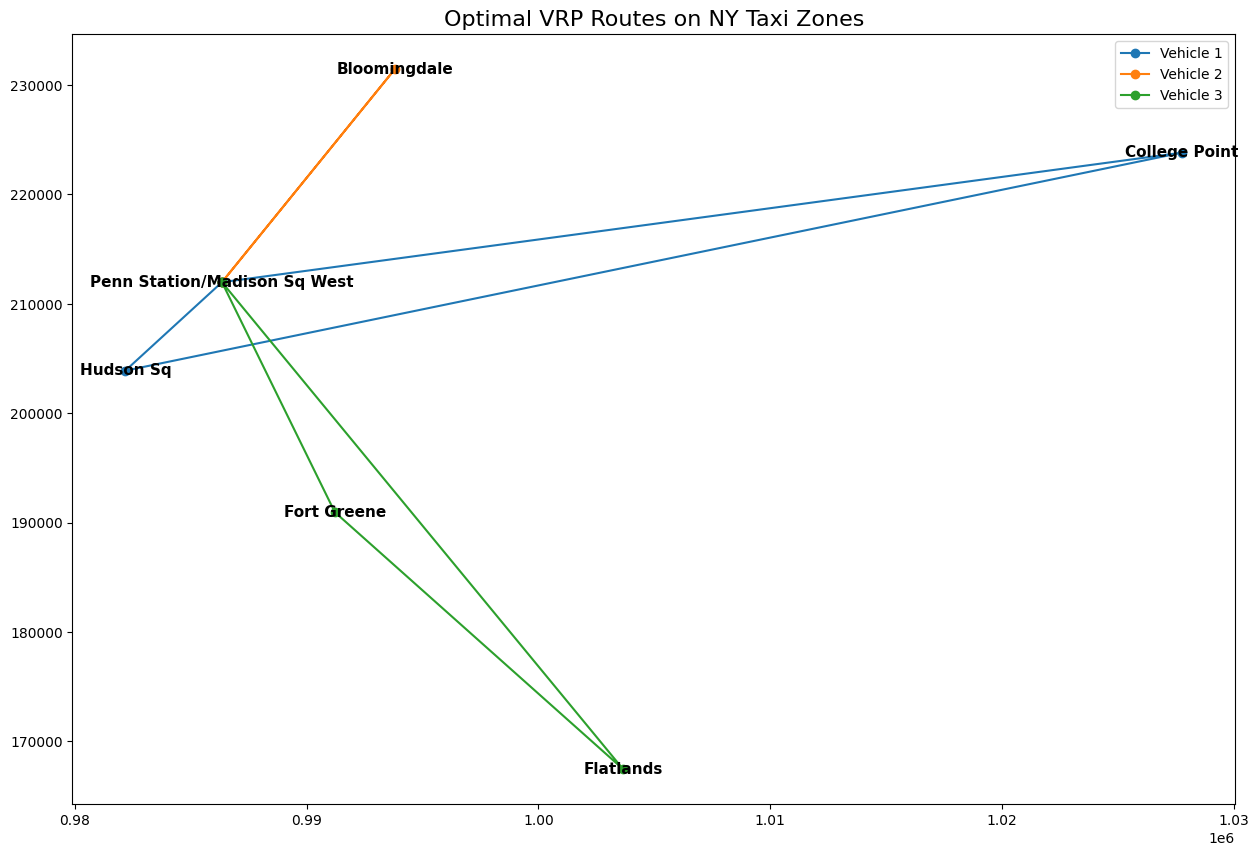

In [35]:
zones = ['Penn Station/Madison Sq West', 'Bloomingdale', 'College Point', 'Hudson Sq', 'Flatlands', 'Fort Greene']
demands = {'Penn Station/Madison Sq West': 0, 'Bloomingdale': 2, 'College Point': 3, 'Hudson Sq': 1, 'Flatlands': 1, 'Fort Greene': 2}
vehicle_capacities = [4, 3, 3]

# Crear una instancia de la clase
vrp = VehicleRoutingProblem(merged_data, zones, demands, vehicle_capacities)

# Resolver el problema
vrp.solve()

# Imprimir la solución
vrp.print_solution()

# Graficar la solución
vrp.plot_solution()